In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import os

DATA_PATH = '/opt/ml/input/data'

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

df = pd.concat([train_df, test_df]).sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

del_answerCode_df = pd.concat([train_df, test_df[test_df['answerCode'] != -1]]).sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 8.21 s, sys: 740 ms, total: 8.95 s
Wall time: 8.96 s


# 문항별 정답률

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

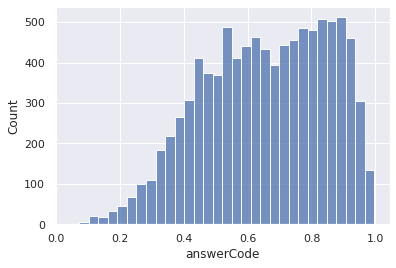

In [3]:
sns.histplot(del_answerCode_df.groupby('assessmentItemID').mean()['answerCode'])

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

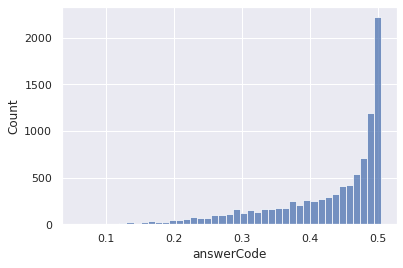

In [4]:
sns.histplot(del_answerCode_df.groupby('assessmentItemID').std()['answerCode'])

문항별로 정답률의 차이가 존재하며, 단순히 문항별 정답률로 예측 시에 0.7638의 성능을 보임

따라서 중요한 변수라고 생각됨

# 문항별 풀이 시간

In [5]:
def get_now_elapsed(df):
    
    diff = df.loc[:, ['userID','Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())
    df['now_elapsed'] = diff
    df['now_elapsed'] = df['now_elapsed'].apply(lambda x : x if x < 650 and x >=0 else 0)
    df['now_elapsed'] = df['now_elapsed']

    return df

df = get_now_elapsed(df = df)

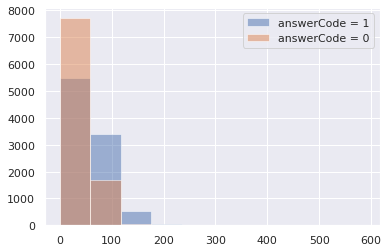

In [6]:
min_val = min(df[df['answerCode'] == 1].groupby('assessmentItemID').mean()['now_elapsed'].min(), df[df['answerCode'] == 0].groupby('assessmentItemID').mean()['now_elapsed'].min())
max_val = max(df[df['answerCode'] == 1].groupby('assessmentItemID').mean()['now_elapsed'].max(), df[df['answerCode'] == 0].groupby('assessmentItemID').mean()['now_elapsed'].max())

plt.hist(df[df['answerCode'] == 1].groupby('assessmentItemID').mean()['now_elapsed'], label = 'answerCode = 1', range = (min_val, max_val), alpha=0.5)
plt.hist(df[df['answerCode'] == 0].groupby('assessmentItemID').mean()['now_elapsed'], label = 'answerCode = 0', range = (min_val, max_val), alpha=0.5)
plt.legend()
plt.show()

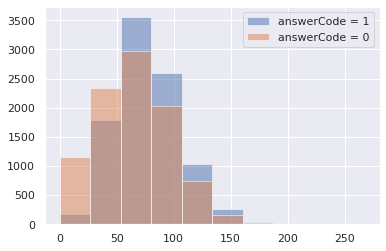

In [7]:
min_val = min(df[df['answerCode'] == 1].groupby('assessmentItemID').std()['now_elapsed'].min(), df[df['answerCode'] == 0].groupby('assessmentItemID').std()['now_elapsed'].min())
max_val = max(df[df['answerCode'] == 1].groupby('assessmentItemID').std()['now_elapsed'].max(), df[df['answerCode'] == 0].groupby('assessmentItemID').std()['now_elapsed'].max())

plt.hist(df[df['answerCode'] == 1].groupby('assessmentItemID').std()['now_elapsed'], label = 'answerCode = 1', range = (min_val, max_val), alpha=0.5)
plt.hist(df[df['answerCode'] == 0].groupby('assessmentItemID').std()['now_elapsed'], label = 'answerCode = 0', range = (min_val, max_val), alpha=0.5)
plt.legend()
plt.show()

풀이 시간이 짧을 수록 틀릴 확률이 더 높아진다는 것을 알 수 있음

따라서 해당 문항을 맞춘 사람들의 평균 풀이 시간을 변수로 넣어서 모델이 조금 더 해당 문제 정답 풀이 시간과 유저의 풀이 시간 간의 차이를 이해할 수 있도록 해줘야 함 

# 유저별 푼 문항의 개수

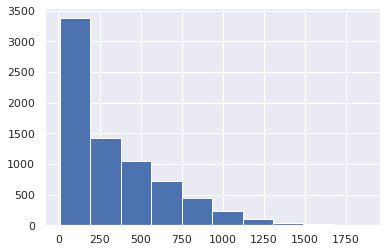

In [8]:
plt.hist(df.groupby('userID').nunique()['assessmentItemID'])
plt.show()

# 유저의 문제 풀이 경향성

In [9]:
# 최신 문제 풀이 시간 - 각 문제 풀이 시간 (요거 가지고 데이터 짜르면 될 듯 함)
def get_relevance_elapsed(df):
    return_df = []
    df = df.copy()
    group_df = df.groupby('userID')

    for userID, g_df in group_df:
        last_df = g_df.iloc[-1:, :]
        g_df['relevance_elapsed'] = last_df['Timestamp'].values[0] - g_df['Timestamp']
        g_df['relevance_elapsed'] = g_df['relevance_elapsed'].dt.days
        return_df.append(g_df)

    return_df = pd.concat(return_df).sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
    return return_df
    
df = get_relevance_elapsed(df = df)

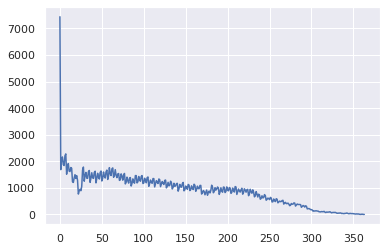

In [23]:
x = df.groupby('relevance_elapsed').nunique()['userID'].index.tolist()
y = df.groupby('relevance_elapsed').nunique()['userID'].tolist()

plt.plot(x, y)

해당 어플을 장기간 이용하는 사용자는 그렇게 많지 않은 것으로 보임

# 시간에 따른 정답률 차이

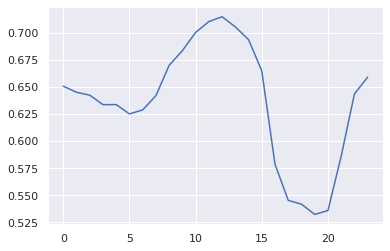

In [10]:
del_answerCode_df['hour'] = del_answerCode_df['Timestamp'].dt.hour
plt.plot(del_answerCode_df.groupby('hour').mean()['answerCode'])
plt.show()

특정 시간대에 정답률이 낮아지는 것을 확인할 수 있음

# 요일에 따른 정답률 차이

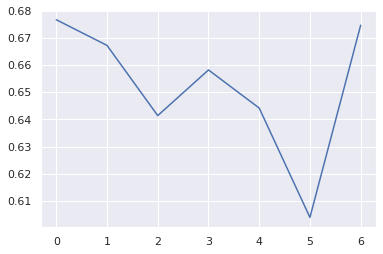

In [11]:
del_answerCode_df['dayofweek'] = del_answerCode_df['Timestamp'].dt.dayofweek
plt.plot(del_answerCode_df.groupby('dayofweek').mean()['answerCode'])
plt.show()

특정 요일에 정답률이 낮아지는 것을 확인할 수 있음

# 시험지별 정답률

<AxesSubplot:xlabel='answerCode', ylabel='Count'>

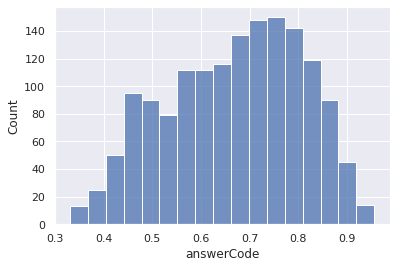

In [12]:
sns.histplot(del_answerCode_df.groupby('testId').mean()['answerCode'])

시험지 자체에 대한 난이도를 파악하는데에는 나름 괜찮은 정보가 될 수 있다고 생각됨

하지만 우리는 문항별 평균 정답률을 사용하기 때문에, 이미 관련된 변수는 존재한다고 생각됨

# 시험지별 풀이 시간

<AxesSubplot:xlabel='now_elapsed', ylabel='Count'>

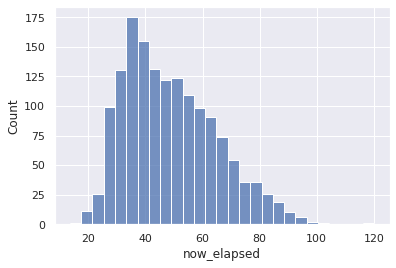

In [13]:
sns.histplot(df.groupby('testId').mean()['now_elapsed'])

# 유저별 푼 시험지의 개수

<AxesSubplot:xlabel='testId', ylabel='Count'>

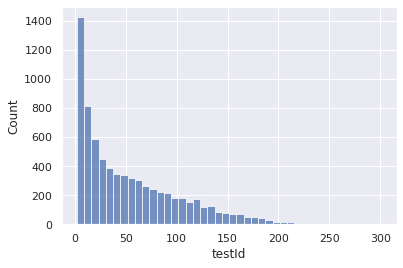

In [28]:
sns.histplot(df.groupby('userID').nunique()['testId'])

# 시험지별 문항의 개수

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='assessmentItemID', ylabel='count'>

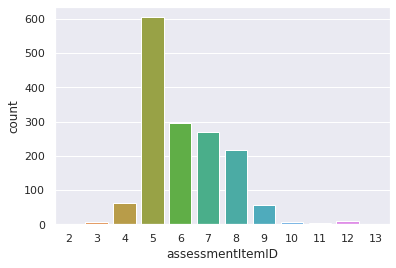

In [26]:
sns.countplot(df.groupby('testId').nunique()['assessmentItemID'])

# 시험지 대분류에 따른 정답률 차이

<AxesSubplot:xlabel='large_paper_number'>

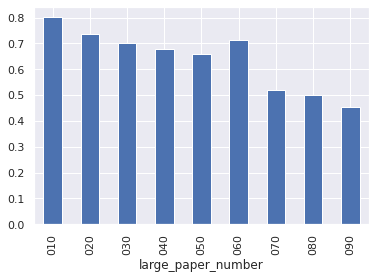

In [24]:
def get_large_paper_number(x):
            return x[1:4]
        
del_answerCode_df['large_paper_number'] = del_answerCode_df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))
del_answerCode_df.groupby('large_paper_number').mean()['answerCode'].plot.bar()

시험지 대분류에 따른 정답률 차이가 존재함

# 시험지별 킬러 문제를 푼 사람과 풀지 못한 사람의 정답률 차이

In [29]:
from tqdm import tqdm

testId2assessmentItemID_mean = {}

kill_answer = 0
kill_answer_user = 0
kill_not_answer = 0
kill_not_answer_user = 0

two_user = 0

testId_g_df = del_answerCode_df.groupby('testId')

for testId, g in tqdm(testId_g_df):
    kill = g.groupby('assessmentItemID').mean().sort_values('answerCode').index.tolist()[0]
    userID_g_df = g.groupby('userID')
    for userID, gg in userID_g_df:
        try:
            if gg.set_index('assessmentItemID').loc[kill, 'answerCode'] == 1:
                kill_answer += gg['answerCode'].mean()
                kill_answer_user += 1
            else:
                kill_not_answer += gg['answerCode'].mean()
                kill_not_answer_user += 1
        # 해당 문제를 2개 푼 사람이 존재함
        except:
            two_user += 1

100%|██████████| 1537/1537 [04:52<00:00,  5.25it/s]


In [30]:
print(f' 킬러문제를 푼 사람의 정답율: {kill_answer / kill_answer_user}, 킬러 문제를 풀지 못한 사람의 정답률 : {kill_not_answer / kill_not_answer_user}')

 킬러문제를 푼 사람의 정답율: 0.8809003532175123, 킬러 문제를 풀지 못한 사람의 정답률 : 0.4819674490344422


킬러 문제를 푼 사람과 풀지 못한 사람의 정답률 차이가 존재하기 때문에

킬러 문제 풀이 여부는 해당 사람의 시험에 대한 지식 정도를 의미함

따라서 문항의 평균 정답률을 변수로 사용하여 해당 문제가 킬러 문제인지 아닌지 모델이 판단할 수 있게 헤주면 좋을 듯 함